### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBB' #BSSSBSBB

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12816
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     1|[C8 5A E8 59 F0 5...|1897.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[80 58 00 00 20 5...|1898.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[60 59 00 53 40 5...|1899.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     6|[00 C6 00 4F 00 4...|1900.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[28 58 40 56 30 5...|1901.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00018859')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00198301')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s'" %('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates 
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00018859'
108 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       PRCP|USC00018859|    26|[00 00 00 00 00 0...|1894.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       PRCP|USC00018859|     0|[00 00 00 00 50 5...|1895.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(108, 365)

### Script for plotting yearly plots

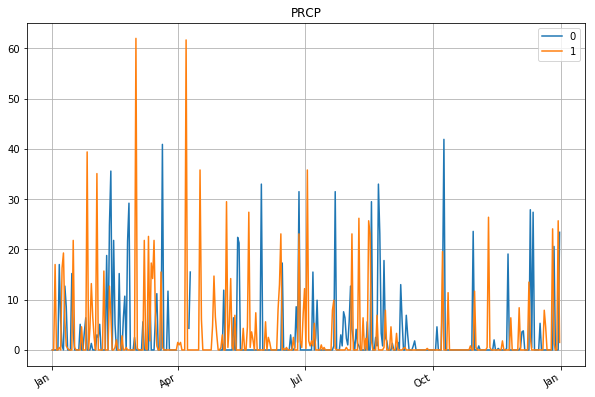

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
x=YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


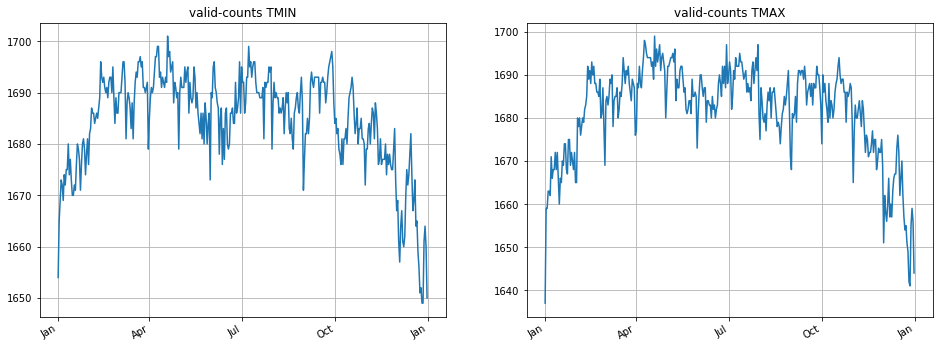

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

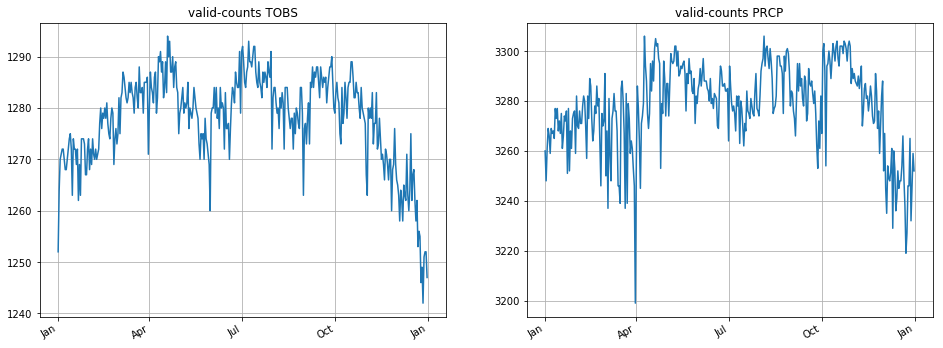

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

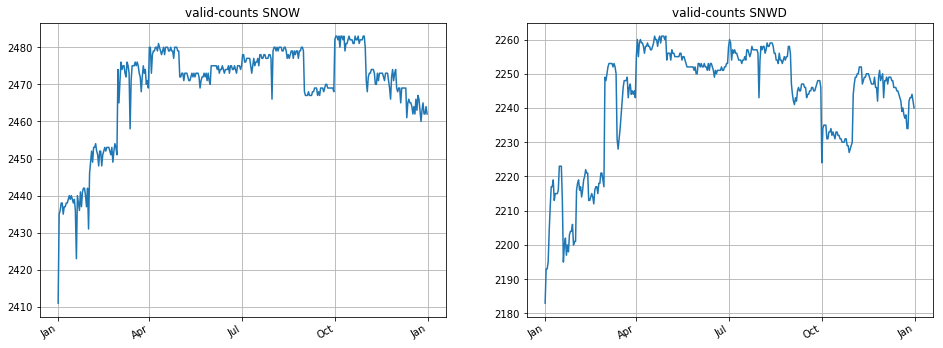

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    if m=='TMIN' or m=='TMAX' or m=='TOBS' or m=='PRCP':
        graphs=np.vstack([(mean-std)/10,mean/10,(mean+std)/10]).transpose()
    else:
        graphs=np.vstack([(mean-std),mean,(mean+std)]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

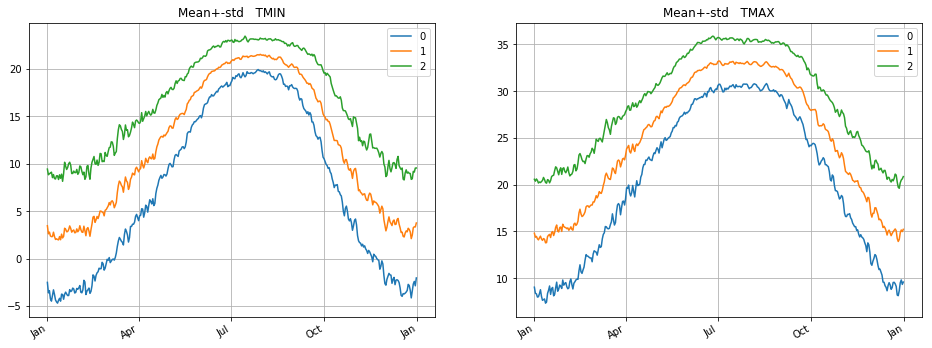

In [9]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

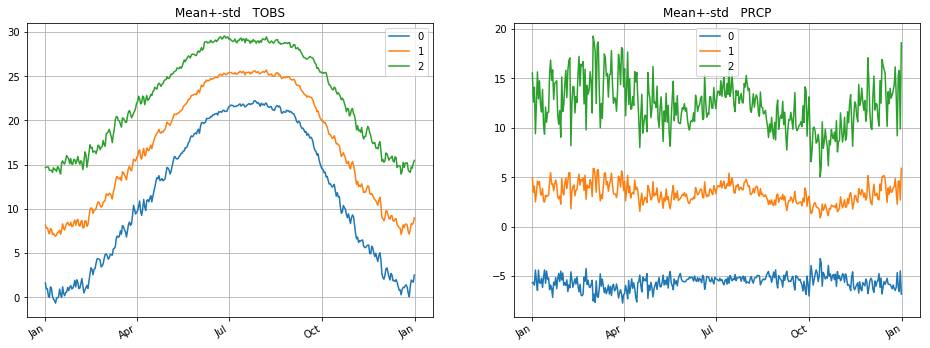

In [10]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

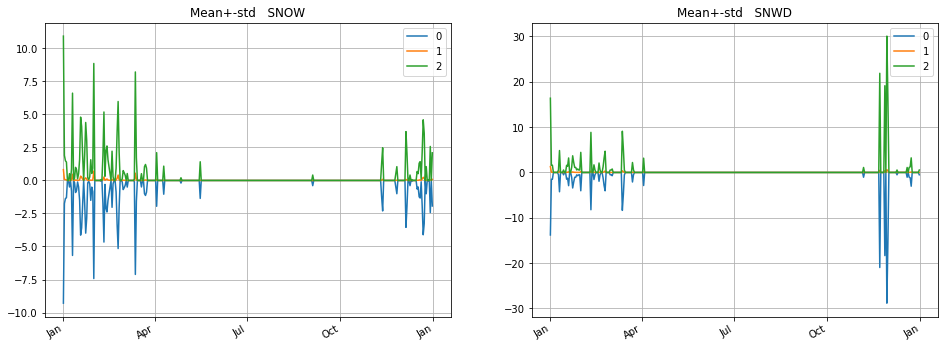

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

 **Correlation Heatmap Plotting**

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

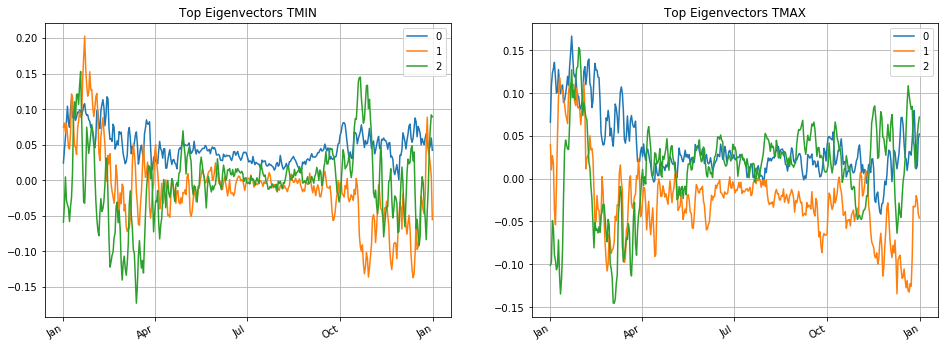

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

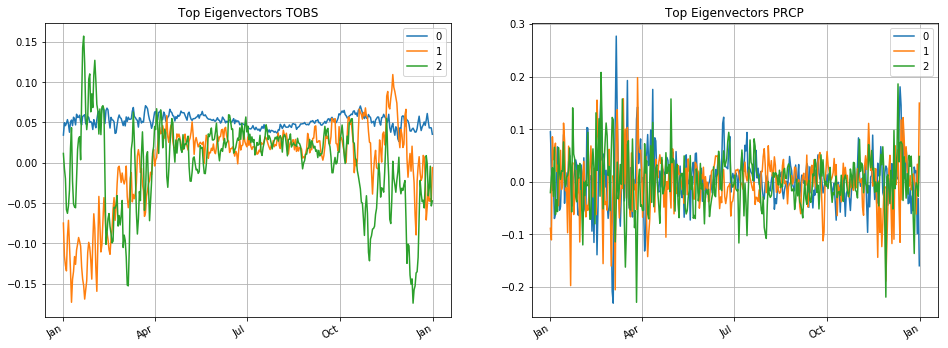

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

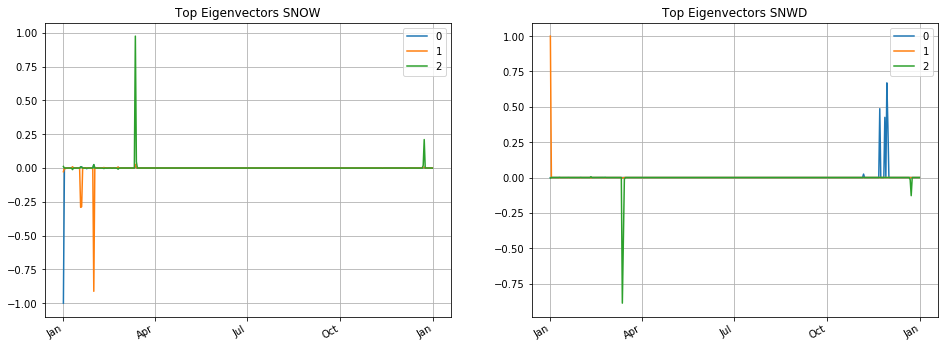

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    print(list(cumsum(EV[:k]))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

[ 0.08165632  0.12193795  0.15446509  0.18577437  0.21531887]
[ 0.34167698  0.3715723   0.39546185  0.41789075  0.43833039]
[ 0.05753613  0.09596648  0.13198379  0.16398421  0.19380731]


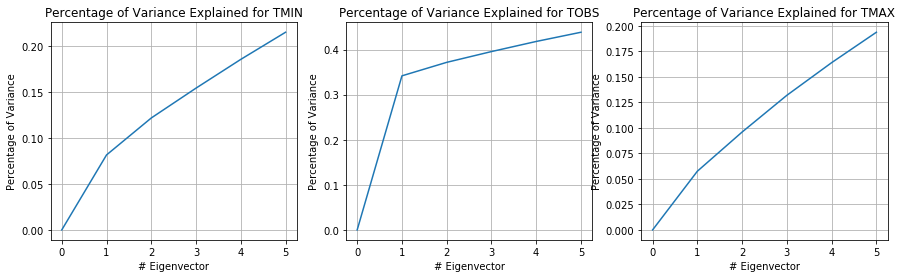

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS','TMAX']: 
    pltVarExplained(j)
    j+=1

[ 0.19112222  0.33750108  0.45185023  0.52243099  0.58200765]
[ 0.77972953  0.87129978  0.90930254  0.9386098   0.94962459]
[ 0.01621275  0.03117963  0.04558023  0.05913495  0.07214175]


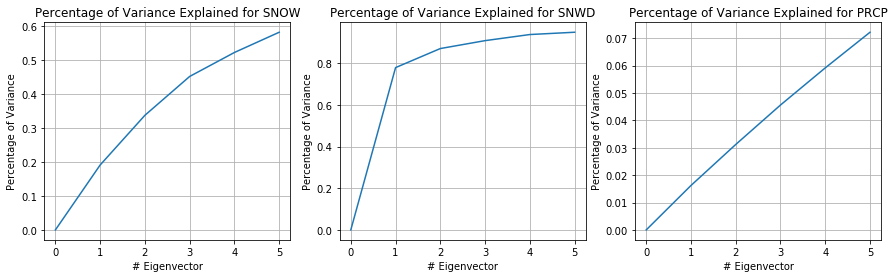

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()

/root/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


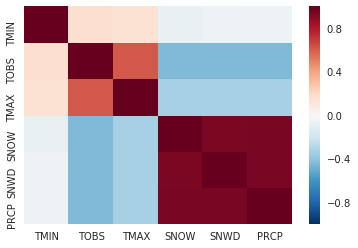

In [20]:
#import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline

measurements = STAT.keys()
dict_mean = {}
for meas in measurements:
    dict_mean[meas]=STAT[meas]['Mean']
corr_df = pd.DataFrame(dict_mean)

correlation_mat = corr_df.corr('kendall')

#plot the heatmap
sns.heatmap(correlation_mat, 
        xticklabels=['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'],
        yticklabels=['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])

